In [342]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import keras
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer
from keras.layers import GaussianNoise

In [312]:
# Override how Pandas Datareader reads data
yf.pdr_override()

In [313]:
# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year - 2, today.month, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)
stock = "ZOMATO.NS"

2022-06-03 00:00:00
2024-06-03 00:00:00


In [314]:
# Acquiring the data from YahooFinance
df = yf.download(stock, start, end)

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-27,183.899994,185.449997,178.399994,183.649994,183.649994,47652253
2024-05-28,184.350006,184.800003,180.399994,181.600006,181.600006,34444521
2024-05-29,180.550003,185.399994,180.000000,183.350006,183.350006,30888209
2024-05-30,183.000000,185.000000,179.000000,180.600006,180.600006,33684173
2024-05-31,178.800003,183.149994,171.250000,179.149994,179.149994,149283415


In [315]:
# Ticker for searching news
stockraw = stock[:-3]

stockraw

'ZOMATO'

In [316]:
# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
print(webpage)

Output hidden; open in https://colab.research.google.com to view.

In [317]:
# Extracting headlines and the dates when they were published to find sentiments
with requests.Session() as c:
    soup = BeautifulSoup(webpage, 'html.parser')

    # Extract titles and datetimes simultaneously
    titles = soup.find_all('a', class_='JtKRv')
    datetimes = soup.find_all('time', class_='hvbAAd')

    # Create lists to store extracted data
    dates_list = []
    titles_list = []

    for title, datetime_tag in zip(titles, datetimes):
        title_text = title.text.strip()  # Remove leading/trailing whitespace from title
        datetime_str = datetime_tag['datetime']
        formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')  # Parse datetime string

        # Append data to respective lists
        dates_list.append(formatted_datetime.date())
        titles_list.append(title_text)

    # Create DataFrame
    df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

    # Print DataFrame
    print(df2.head)

<bound method NDFrame.head of           Date                                           Headline
0   2024-06-03  'Order if absolutely necessary': Zomato asks c...
1   2024-06-03  Amid heatwave in India, Zomato urges customers...
2   2024-06-02  Zomato says ‘avoid ordering from us during.......
3   2024-06-02  Zomato urges customers to not order during pea...
4   2024-06-03  Zomato requests its customers to avoid orderin...
..         ...                                                ...
91  2024-05-13  Zomato Q4 results: Net profit at ₹175 crore ve...
92  2024-05-12  Q4 results: Zomato, Bharti Airtel, HAL, GAIL, ...
93  2024-05-27  Zomato, Swiggy, BlinkIt cheer with fun posts a...
94  2024-05-13  Zomato Q4 result: PAT Rs 175cr; fourth consecu...
95  2024-06-02  Zomato says 'avoid ordering from us during.......

[96 rows x 2 columns]>


In [318]:
# Loading the tokenizer to generate tokens and model to perform sentiment analysis
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [319]:
# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)
print(encoded_headlines)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'input_ids': tensor([[    0,   108, 45613,   114,  3668,  2139, 13373,   525,  1075,  3938,
          6990,   916,     7,  1877, 12926,   148,  1390,   722,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[    0, 42332,  2859, 20654,    11,   666,     6,   525,  1075,  3938,
         19288,   916,     7,  1877, 12926,   148,    44,   711, 37271,    17,
            27,  1390,   131, 30555,  2625,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}, {'input_ids': tensor([[    0,  1301,  1075,  3938,   161,    44,   711, 40623, 12926,    31,
           201,   148, 17220,    17,    27,   131,  1161, 38839,  1394,    24,
             7,   128, 22641,   265,   108,  1721,  1260,  2090,   491,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])}, {'input_ids': t

In [320]:
# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]  # Assuming 'labels' are ordered as [negative, neutral, positive]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Print the tweet sentiments
for i in headline_sentiments:
    print(i)

-0.29941013
-0.50776666
-0.4075328
-0.5480576
-0.37950915
0.038263243
-0.36522946
-0.1862033
0.06659452
0.39067698
-0.65578026
-0.22065718
-0.55626285
-0.33894733
-0.30795076
-0.5158413
0.0374894
-0.6284213
0.064670704
-0.6368169
-0.4488204
-0.8143489
-0.71689653
-0.3672657
-0.15547332
-0.28560764
0.27359316
-0.05553978
0.8484369
-0.6904553
-0.1449284
-0.0062841102
-0.7392995
0.12802392
-0.1616154
-0.6553372
-0.31379795
-0.37173933
-0.35844803
-0.58381903
-0.063012935
0.077591
-0.36758617
-0.025127884
-0.08146526
-0.42939693
-0.31063783
-0.63720673
0.046949573
0.22386533
-0.19262844
-0.14655337
0.09895675
0.013081405
-0.39745885
-0.15811417
-0.2807452
0.8466177
0.074866876
0.22843117
0.23294072
0.22833471
-0.052152634
-0.58563954
-0.08113378
0.3126529
-0.24320573
0.7819426
0.16943514
-0.3402025
0.5014372
0.0729883
-0.6706594
-0.40178624
-0.22425658
-0.2775082
0.34918484
-0.08708508
0.010743957
0.15173088
-0.7821525
0.47763368
-0.3839098
-0.018074095
0.5059461
-0.3364129
0.290892
-0.540

In [321]:
# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Print the DataFrame with the added column
print(df2)

          Date                                           Headline  Sentiments
0   2024-06-03  'Order if absolutely necessary': Zomato asks c...   -0.299410
1   2024-06-03  Amid heatwave in India, Zomato urges customers...   -0.507767
2   2024-06-02  Zomato says ‘avoid ordering from us during.......   -0.407533
3   2024-06-02  Zomato urges customers to not order during pea...   -0.548058
4   2024-06-03  Zomato requests its customers to avoid orderin...   -0.379509
..         ...                                                ...         ...
91  2024-05-13  Zomato Q4 results: Net profit at ₹175 crore ve...    0.042391
92  2024-05-12  Q4 results: Zomato, Bharti Airtel, HAL, GAIL, ...    0.044476
93  2024-05-27  Zomato, Swiggy, BlinkIt cheer with fun posts a...    0.897248
94  2024-05-13  Zomato Q4 result: PAT Rs 175cr; fourth consecu...    0.124214
95  2024-06-02  Zomato says 'avoid ordering from us during.......   -0.343325

[96 rows x 3 columns]


In [322]:
# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Print the DataFrame with one row per date and the average sentiment for each day
print(average_sentiments)

         Date  Sentiments
0  2024-05-12    0.044476
1  2024-05-13    0.284836
2  2024-05-14    0.052080
3  2024-05-15    0.290892
4  2024-05-20    0.072988
5  2024-05-21    0.172390
6  2024-05-23    0.781943
7  2024-05-27    0.267923
8  2024-05-28    0.098957
9  2024-05-29    0.221514
10 2024-05-30   -0.056106
11 2024-05-31   -0.291430
12 2024-06-01    0.260442
13 2024-06-02   -0.129447
14 2024-06-03   -0.260709


In [323]:
# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

# If you want to overwrite the 'Sentiments' column with 0 where there's no match
# merged_df['Sentiments'].fillna(0, inplace=True)

merged_df.tail(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiments
471,2024-05-03,196.800003,200.350006,193.100006,197.250000,197.250000,37882274,0.000000
472,2024-05-06,199.000000,202.000000,194.500000,195.699997,195.699997,26394239,0.000000
473,2024-05-07,196.149994,196.350006,182.350006,191.449997,191.449997,48161265,0.000000
474,2024-05-08,190.649994,196.000000,187.300003,195.449997,195.449997,47941406,0.000000
475,2024-05-09,195.000000,199.699997,193.100006,195.250000,195.250000,47274769,0.000000
476,2024-05-10,196.350006,205.000000,189.899994,201.300003,201.300003,52717901,0.000000
477,2024-05-13,205.800003,207.199997,186.750000,194.300003,194.300003,114135952,0.284836
478,2024-05-14,191.699997,193.449997,182.100006,187.300003,187.300003,110070781,0.052080
479,2024-05-15,188.800003,193.399994,183.149994,192.000000,192.000000,44772997,0.290892
480,2024-05-16,192.899994,195.850006,189.000000,195.199997,195.199997,35478593,0.000000


In [324]:
print(merged_df.index.dtype)

int64


In [325]:
# Isolating dates to plot graphs more conveniently
train_dates = pd.to_datetime(merged_df['Date'])

print(train_dates)

0     2022-06-03
1     2022-06-06
2     2022-06-07
3     2022-06-08
4     2022-06-09
         ...    
486   2024-05-27
487   2024-05-28
488   2024-05-29
489   2024-05-30
490   2024-05-31
Name: Date, Length: 491, dtype: datetime64[ns]


In [326]:
# Isolate variables for training
cols = list(merged_df)[1:8]
print(cols)
cols2 = list(merged_df)[1:7]
print(cols2)
cols3 = list(merged_df)[1:6]
print(cols3)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Open', 'High', 'Low', 'Close', 'Adj Close']


<Axes: >

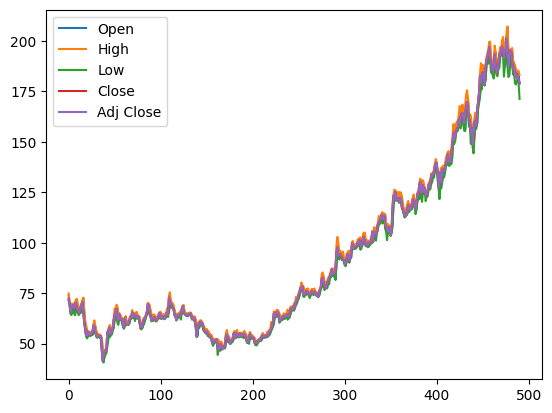

In [327]:
# Displaying Open, High, Low, Close and Adjusted Closing price
df_for_display = merged_df[cols3].astype(float)
df_for_display.plot.line()

<Axes: >

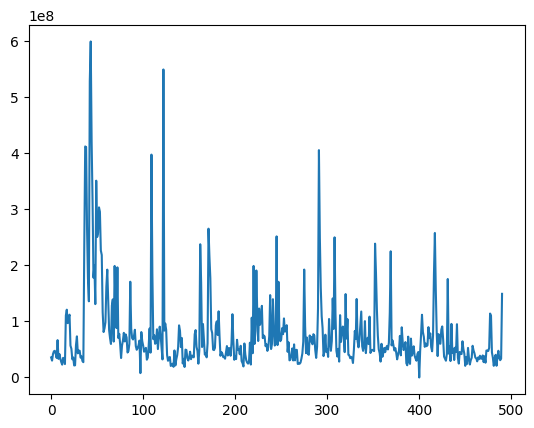

In [328]:
# Displaying traded Volume
df_for_display = merged_df['Volume'].astype(float)
df_for_display.plot.line()

<Axes: >

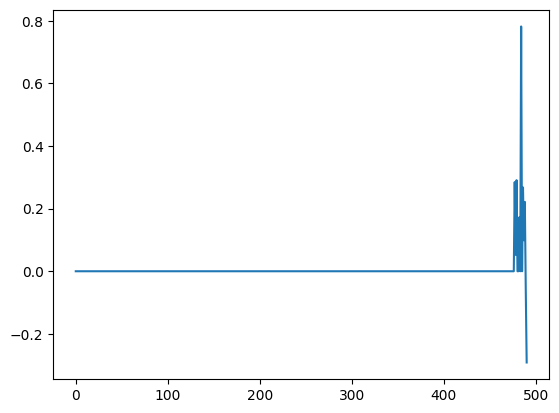

In [329]:
# Displaying Sentiments
df_for_display = merged_df['Sentiments'].astype(float)
df_for_display.plot.line()

In [330]:
# Storing all data to be fed to the model
df_for_training = merged_df[cols].astype(float)

df_for_training

,Open,High,Low,Close,Adj Close,Volume,Sentiments
0,73.900002,74.849998,71.199997,72.150002,72.150002,35779760.0,0.000000
1,70.000000,71.199997,69.199997,69.900002,69.900002,30078469.0,0.000000
2,69.699997,69.699997,64.750000,65.400002,65.400002,41755337.0,0.000000
3,66.000000,68.599998,64.099998,67.150002,67.150002,46697875.0,0.000000
4,66.199997,69.699997,65.000000,68.699997,68.699997,47653877.0,0.000000
...,...,...,...,...,...,...,...
486,183.899994,185.449997,178.399994,183.649994,183.649994,47652253.0,0.267923
487,184.350006,184.800003,180.399994,181.600006,181.600006,34444521.0,0.098957
488,180.550003,185.399994,180.000000,183.350006,183.350006,30888209.0,0.221514
489,183.000000,185.000000,179.000000,180.600006,180.600006,33684173.0,-0.056106


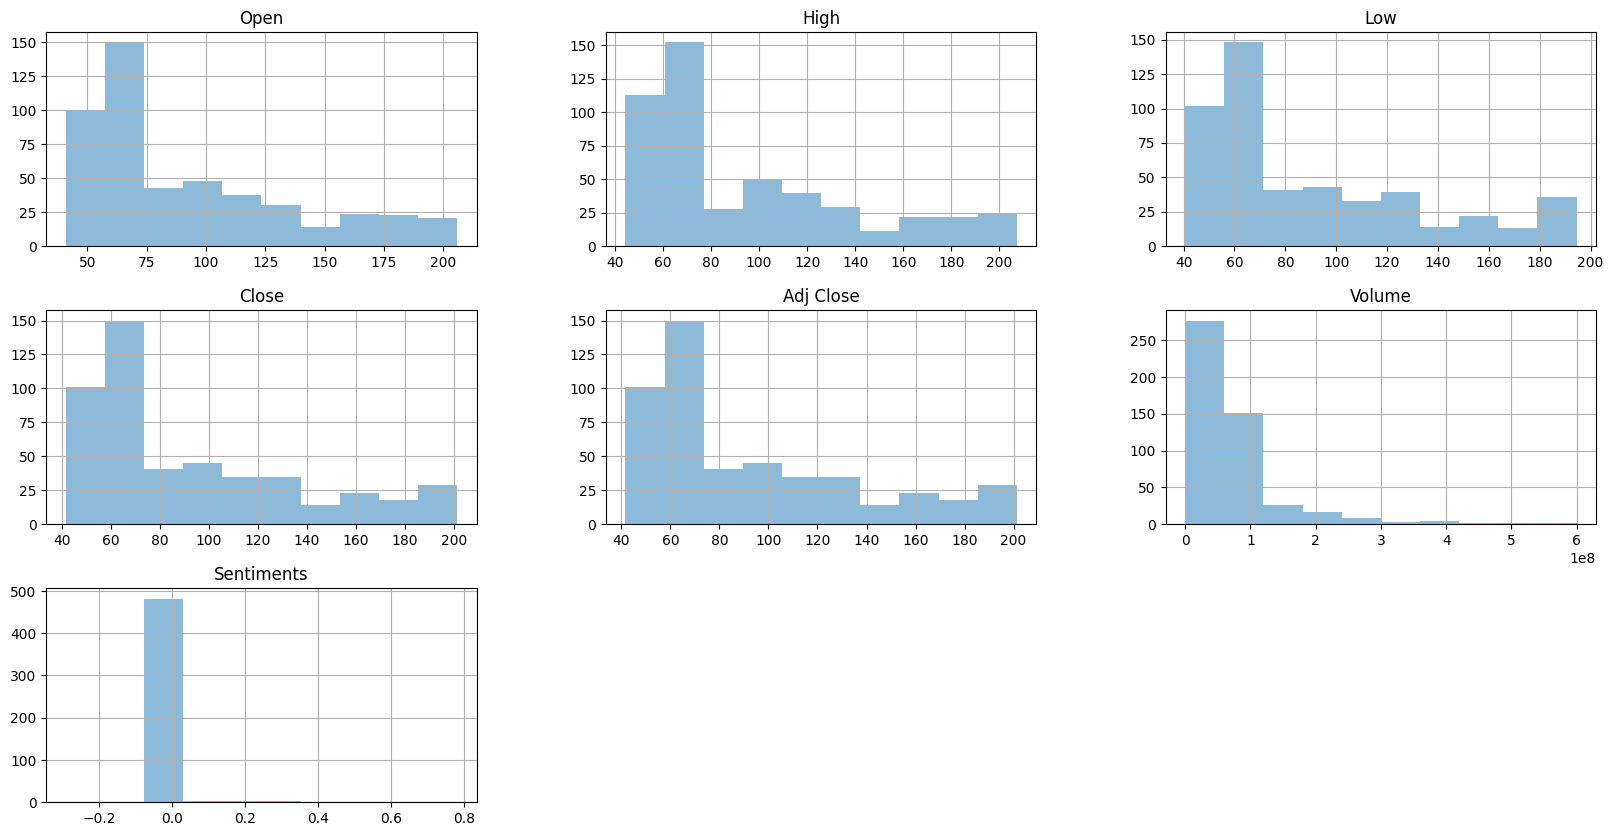

In [331]:
# Plotting the type of distribution of each column in df_for_training
df_for_training.hist(alpha=0.5, figsize=(20,10))
plt.show()

In [332]:
# Selecting the features
dataFrame = merged_df

dataFrame

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiments
0,2022-06-03,73.900002,74.849998,71.199997,72.150002,72.150002,35779760,0.000000
1,2022-06-06,70.000000,71.199997,69.199997,69.900002,69.900002,30078469,0.000000
2,2022-06-07,69.699997,69.699997,64.750000,65.400002,65.400002,41755337,0.000000
3,2022-06-08,66.000000,68.599998,64.099998,67.150002,67.150002,46697875,0.000000
4,2022-06-09,66.199997,69.699997,65.000000,68.699997,68.699997,47653877,0.000000
...,...,...,...,...,...,...,...,...
486,2024-05-27,183.899994,185.449997,178.399994,183.649994,183.649994,47652253,0.267923
487,2024-05-28,184.350006,184.800003,180.399994,181.600006,181.600006,34444521,0.098957
488,2024-05-29,180.550003,185.399994,180.000000,183.350006,183.350006,30888209,0.221514
489,2024-05-30,183.000000,185.000000,179.000000,180.600006,180.600006,33684173,-0.056106


In [333]:
# To handle missing values
imputer = SimpleImputer(missing_values=np.nan)

# Removing date and changing index
dataFrame.drop(columns=['Date'], inplace=True)

# Handling Missing values
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
print(dataFrame.shape)

# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
print(list(dataFrame.columns))
print(df_scaled.shape)
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['Open', 'Close']] = target_scaler.fit_transform(dataFrame[['Open', 'Close']].to_numpy())
df_scaled = df_scaled.astype(float)
print(df_scaled.shape)

(491, 7)
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']
(491, 7)
(491, 7)


In [334]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)

In [335]:
# Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]
print(xVal.shape)
print(yVal.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(471, 20, 7)
(471, 2)
(400, 20, 7)
(400, 2)
(71, 20, 7)
(71, 2)


In [348]:
# Building the model
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(2, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 200)               166400    
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 402       
                                                                 
Total params: 166802 (651.57 KB)
Trainable params: 166802 (651.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [349]:
# Fitting the data to the model
history = multivariate_lstm.fit(X_train, y_train, epochs=100)

Epoch 1/100
13/13 [==============================] - 5s 90ms/step - loss: 0.0124 - MAE: 0.0784
Epoch 2/100
13/13 [==============================] - 1s 79ms/step - loss: 0.0024 - MAE: 0.0351
Epoch 3/100
13/13 [==============================] - 1s 74ms/step - loss: 0.0011 - MAE: 0.0247
Epoch 4/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0011 - MAE: 0.0247
Epoch 5/100
13/13 [==============================] - 1s 82ms/step - loss: 8.9925e-04 - MAE: 0.0224
Epoch 6/100
13/13 [==============================] - 1s 81ms/step - loss: 9.4050e-04 - MAE: 0.0225
Epoch 7/100
13/13 [==============================] - 0s 34ms/step - loss: 7.7433e-04 - MAE: 0.0207
Epoch 8/100
13/13 [==============================] - 0s 34ms/step - loss: 9.1925e-04 - MAE: 0.0221
Epoch 9/100
13/13 [==============================] - 0s 33ms/step - loss: 9.4958e-04 - MAE: 0.0226
Epoch 10/100
13/13 [==============================] - 0s 36ms/step - loss: 7.9500e-04 - MAE: 0.0209
Epoch 11/100
13/13 [=====

In [350]:
list(merged_df.columns)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']

3/3 [==============================] - 0s 18ms/step


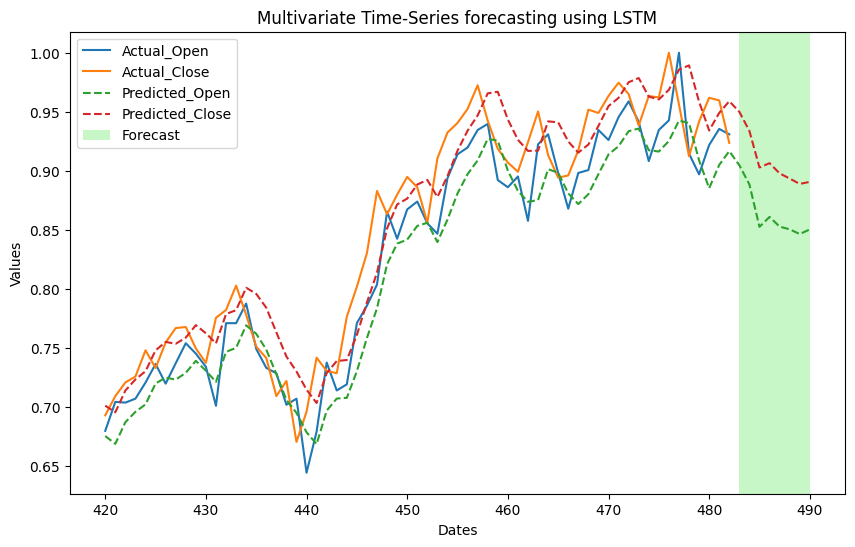

In [353]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
	'Predicted_Open': predicted_values[:, 0],
	'Predicted_Close': predicted_values[:, 1],
	'Actual_Open': y_test[:, 0],
	'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()


In [347]:
predicted_values

array([[0.66536903, 0.69563675],
       [0.6720567 , 0.7025471 ],
       [0.6815914 , 0.71292585],
       [0.69015276, 0.7222442 ],
       [0.6982496 , 0.7308359 ],
       [0.7082206 , 0.7415766 ],
       [0.717379  , 0.7510634 ],
       [0.7244104 , 0.75808555],
       [0.73109055, 0.76549774],
       [0.73814416, 0.7733709 ],
       [0.74210227, 0.7770204 ],
       [0.7441362 , 0.7785212 ],
       [0.75152075, 0.7854244 ],
       [0.756032  , 0.79196876],
       [0.76332545, 0.8004045 ],
       [0.76755714, 0.80484736],
       [0.7696619 , 0.8058384 ],
       [0.76765895, 0.80366784],
       [0.76323104, 0.7977168 ],
       [0.75681806, 0.7911152 ],
       [0.7485949 , 0.782271  ],
       [0.73970664, 0.7725038 ],
       [0.7372111 , 0.77107877],
       [0.7351358 , 0.7705644 ],
       [0.7332443 , 0.7690963 ],
       [0.73642814, 0.7727613 ],
       [0.74348176, 0.7812837 ],
       [0.75357294, 0.7922483 ],
       [0.7689245 , 0.80819833],
       [0.7844074 , 0.8247965 ],
       [0.